# Liu_Zihan_Final_Project

Name: Zihan Liu
<br>
Github Username: zihan0324
<br>
USC ID: 1534981630

## Import Depedencies

In [2]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io


In [3]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

'''Code for running on colab
from google.colab import drive
drive.mount('/content/drive')
data_head_dir = Path('./drive/MyDrive/Colab Notebooks/data')
'''

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('../data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

Mounted at /content/drive


In [4]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
# train_ids = load_text_ids('./drive/MyDrive/Colab Notebooks/train_source_images.txt')
# validate_ids = load_text_ids('./drive/MyDrive/Colab Notebooks/val_source_images.txt')
# test_ids = load_text_ids('./drive/MyDrive/Colab Notebooks/test_source_images.txt')

train_ids = load_text_ids('../train_source_images.txt')
validate_ids = load_text_ids('../val_source_images.txt')
test_ids = load_text_ids('../test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

## Loading and pre processing the data

### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [16]:
import random
import tensorflow as tf
from PIL import Image


def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')

        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 8

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

## Transfer Learning

In [17]:
import keras
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Flatten, Dense, Activation, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### Data Augmentation

In [18]:
# Function to apply the data augmentation to a single image
def data_augmentation(image, label):
    # Data augmentation operations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1) # Random brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2) # Random contrast
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2) # Random saturation
    image = tf.image.random_hue(image, max_delta=0.1) # Random hue
    return image, label

# Apply the data augmentation to the training dataset
tf_dataset_train = tf_dataset_train.map(data_augmentation)

### Construct Model

In [19]:
# Create the base model from the pre-trained models
IMG_SHAPE = (299, 299, 3)
# base_model_1 = EfficientNetB0(input_shape=IMG_SHAPE,
#                             include_top=False,
#                             weights='imagenet')
base_model_2 = ResNet50(input_shape=IMG_SHAPE,
                      include_top=False,
                      weights='imagenet')
# base_model_3 = VGG16(input_shape=IMG_SHAPE,
#                     include_top=False,
#                     weights='imagenet')

In [20]:
# Freeze all layers before the last layer
for layer in base_model_2.layers:
    layer.trainable = False

In [21]:
# Add new top layers
x = base_model_2.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

# Define the new model
model = Model(inputs=base_model_2.input, outputs=predictions)

In [22]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),\
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),\
              metrics=['accuracy'])

### Train Model

In [23]:
# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ModelCheckpoint to save the best model
# model_weights_path = './drive/MyDrive/Colab Notebooks/models/rn_model.weights.best.hdf5'
model_weights_path = '../models/rn_model.weights.best.hdf5'
checkpoint = ModelCheckpoint(model_weights_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

# Train the model
history = model.fit(
    tf_dataset_train,
    epochs=15,
    validation_data=tf_dataset_val,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/15
2213/2214 [============================>.] - ETA: 0s - loss: 0.1991 - accuracy: 0.9201
Epoch 1: val_loss improved from inf to 0.36892, saving model to ./drive/MyDrive/Colab Notebooks/models/rn_model.weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2214/2214 [==============================] - 332s 147ms/step - loss: 0.1991 - accuracy: 0.9201 - val_loss: 0.3689 - val_accuracy: 0.8342
Epoch 2/15
2213/2214 [============================>.] - ETA: 0s - loss: 0.1156 - accuracy: 0.9566
Epoch 2: val_loss did not improve from 0.36892
2214/2214 [==============================] - 327s 147ms/step - loss: 0.1158 - accuracy: 0.9565 - val_loss: 0.4299 - val_accuracy: 0.8154
Epoch 3/15
2213/2214 [============================>.] - ETA: 0s - loss: 0.0972 - accuracy: 0.9641
Epoch 3: val_loss improved from 0.36892 to 0.32618, saving model to ./drive/MyDrive/Colab Notebooks/models/rn_model.weights.best.hdf5
2214/2214 [==============================] - 331s 149ms/step - loss: 0.0975 - accuracy: 0.9640 - val_loss: 0.3262 - val_accuracy: 0.8700
Epoch 4/15
2213/2214 [============================>.] - ETA: 0s - loss: 0.0909 - accuracy: 0.9672
Epoch 4: val_loss did not improve from 0.32618
2214/2214 [==============================] - 322s 145ms/step - loss

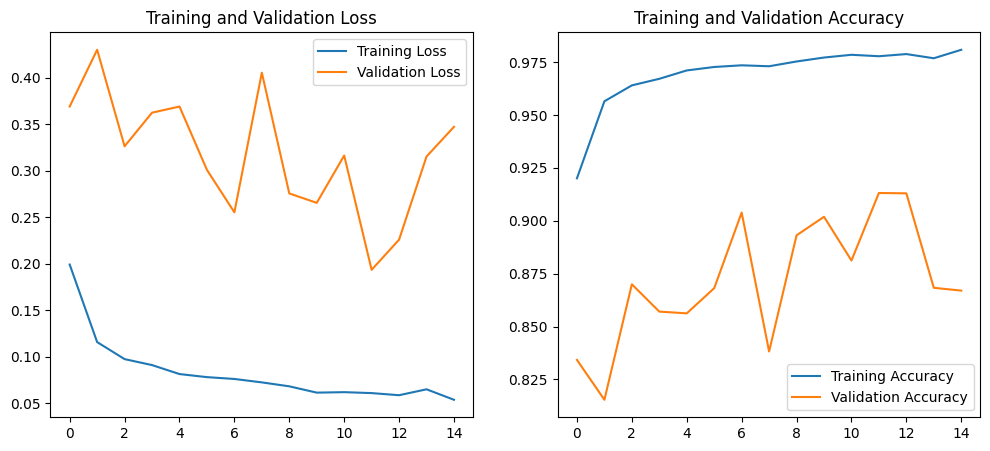

In [24]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

## Evaluate Model

In [25]:
import pandas as pd
from sklearn.metrics import classification_report

def report_pred_results(model, dataset):
    y_pred = np.argmax(model.predict(dataset), axis=1)

    y_actual = np.concatenate([y for x, y in dataset], axis=0)

    print(classification_report(y_actual, y_pred, target_names=['Background', 'Frost']))

# model.load_weights('../models/rn_model.weights.best.hdf5')
# model.load_weights('./drive/MyDrive/Colab Notebooks/models/rn_model.weights.best.hdf5')
print("Training Set:")
report_pred_results(model, tf_dataset_train)
print("Validation Set:")
report_pred_results(model, tf_dataset_val)
print("Test Set:")
report_pred_results(model, tf_dataset_test)

Training Set:
2214/2214 [==============================] - 260s 117ms/step
              precision    recall  f1-score   support

  Background       0.40      0.40      0.40      7047
       Frost       0.61      0.60      0.60     10659

    accuracy                           0.52     17706
   macro avg       0.50      0.50      0.50     17706
weighted avg       0.53      0.52      0.52     17706

Validation Set:
756/756 [==============================] - 61s 80ms/step
              precision    recall  f1-score   support

  Background       0.65      0.54      0.59      3890
       Frost       0.36      0.48      0.41      2154

    accuracy                           0.52      6044
   macro avg       0.51      0.51      0.50      6044
weighted avg       0.55      0.52      0.53      6044

Test Set:
985/985 [==============================] - 80s 80ms/step
              precision    recall  f1-score   support

  Background       0.39      0.36      0.37      3012
       Frost       0.6

In [ ]:
# Save model
# model.save('./drive/MyDrive/Colab Notebooks/models/best_rn_model.keras')
model.save('../models/best_rn_model.keras')